In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

from datetime import datetime as dt
import yfinance as yf

import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.mode.chained_assignment = None  # default='warn'

# [Quadrant Signal Generation](#QUAD)
# [Main Backtester Function](#BTT)
# [Visualization Function](#VIZ)
# [Drawdown Function](#DD)
# [Sharpe Ratio Function](#SHA)
# [CAGR Function](#CAGR)

### Proxy Market Expectations with ^VIX as a reference

In [2]:
def market_expectations(ticker):
    start_str = "2012/1/1"
    end_str = "2022/09/13"
    start_date = dt.strptime(start_str, '%Y/%m/%d').date()
    end_date=dt.strptime(end_str, '%Y/%m/%d').date()
    data=pdr.get_data_yahoo(ticker,start = start_date,end = end_date)["Adj Close"].to_frame()
    data["market_expectations"]= data["Adj Close"]>=20
    data.rename(columns={'Adj Close':'^VIX'},inplace = True)
    return data

weather = market_expectations("^VIX")
weather

,^VIX,market_expectations
Date,,
2012-01-03,22.969999,True
2012-01-04,22.219999,True
2012-01-05,21.480000,True
2012-01-06,20.629999,True
2012-01-09,21.070000,True
...,...,...
2022-09-07,24.639999,True
2022-09-08,23.610001,True
2022-09-09,22.790001,True


### Identify Weights of each All-Weather Portfolio Constituents to benchmark our strategy performance
* (equity) SPY = 18.75%
* (commodity) DBC = 14.5*%
* (corporate credit) LQD = 6.25%
* (emerging market) EMB = 14.58%
* (nominal bond) BND = 25%
* (inflation linked bond) TIP = 20.83%

### Assign LDA-signals to 'weather' variable. pickle, csv or dataframes are accepted

### Below is Our Second Best Performing Signals (Fed Minutes Model) for Strategy Backtesting

In [3]:
LDA_signal = pd.read_pickle('signal.pkl')
LDA_signal.index = pd.to_datetime(LDA_signal.index)

# <a id='QUAD'>Quadrant Signal Generation</a>

In [4]:
# Generate Quadrant Signals from Market Expectations & Regulator States
def regulator_signal(LDA_signal):
    weather['binary'] = LDA_signal['binary']

    weather['binary'] = weather['binary'].ffill()
    weather['regulator_state'] = np.nan
    weather['regulator_state'] = np.where((weather['binary'] == 1),'growth',np.nan)
    weather['regulator_state'] = np.where((weather['binary'] == 2),'inflation',weather['regulator_state'])

    weather['signal'] = np.where((weather['market_expectations'] == True) & (weather['regulator_state'] == 'inflation'),'RI','undefined')
    weather['signal'] = np.where((weather['market_expectations'] == True) & (weather['regulator_state'] == 'growth'),'RG',weather['signal'])
    weather['signal'] = np.where((weather['market_expectations'] == False) & (weather['regulator_state'] == 'inflation'),'FI',weather['signal'])
    weather['signal'] = np.where((weather['market_expectations'] == False) & (weather['regulator_state'] == 'growth'),'FG',weather['signal'])
    
regulator_signal(LDA_signal)

In [5]:
weather

,^VIX,market_expectations,binary,regulator_state,signal
Date,,,,,
2012-01-03,22.969999,True,NaN,nan,undefined
2012-01-04,22.219999,True,NaN,nan,undefined
2012-01-05,21.480000,True,NaN,nan,undefined
2012-01-06,20.629999,True,NaN,nan,undefined
2012-01-09,21.070000,True,NaN,nan,undefined
...,...,...,...,...,...
2022-09-07,24.639999,True,2.0,inflation,RI
2022-09-08,23.610001,True,2.0,inflation,RI
2022-09-09,22.790001,True,2.0,inflation,RI


# <a id='VIZ'>Data Visualization Function</a>

In [6]:
def Plotter(df):
    fig = plt.figure()  
    fig.set_size_inches((14, 14))
    ax_stock = fig.add_axes((0, 0.72, 1, 0.32))
    ax_stock.plot(df.index, df["Strategy Cumulative Returns"],label = "Weather Report")
    ax_stock.plot(df.index, df["All Weather Returns"],label = "All Weather")
    ax_stock.set_title('Weather Report vs All Weather Returns')
    ax_stock.legend()

    plt.show()

In [7]:
Tickers = ['SPY','DBC','LQD','EMB','TIP','BND']

# <a id = 'BTT'>Main Backtester Function</a>

In [8]:
def WRBacktester(Tickers = ['SPY','DBC','LQD','EMB','TIP','BND'], Start = '2012-01-03', End = '2022-09-13', Capital = 100000, Trading_Fee = 0):
    
    ## PARSE STOCK DATA FROM YAHOO FINANCE
    df = yf.download(Tickers ,start = Start, end = End)
    df = pd.DataFrame(df[["Adj Close"]])
    df.columns = df.columns.droplevel()
    
    ## SETUP/RESET NECESSARY COLUMNS FOR STRATEGY EXECUTION
    
    for ticker in Tickers:
        df[f"{ticker}_Signal"] = 0
        df[f"{ticker}_Position"] = 0
        df[f"{ticker}_Execution"] = 0
        df[f"{ticker}_Closing"] = 0
        df[f"{ticker}_Stock_Holding"] = 0
        df[f"{ticker}_Daily_Stock_Value"] = 0
        df[f"{ticker}_Capital"] = Capital
        df[f"{ticker}_Cash"] = Capital

    def Update(df):    
        df[f"{ticker}_Daily_Stock_Value"][i:] = (df[f"{ticker}"][i] * df[f"{ticker}_Stock_Holding"][i])
        df[f"{ticker}_Capital"][i:] = df[f"{ticker}_Cash"][i] + df[f"{ticker}_Daily_Stock_Value"][i]
        
    def CloseTrade(df):
        df[f"{ticker}_Daily_Stock_Value"][i:] = (df[f"{ticker}"][i] * df[f"{ticker}_Stock_Holding"][i])
        df[f"{ticker}_Cash"][i:] = df[f"{ticker}_Cash"][i] + df[f"{ticker}_Daily_Stock_Value"][i] - Trading_Fee
        df[f"{ticker}_Daily_Stock_Value"][i:] = 0
        df[f"{ticker}_Stock_Holding"][i:] = 0
        df[f"{ticker}_Position"][i:] = 0
        df[f"{ticker}_Capital"][i:] = df[f"{ticker}_Cash"][i] 
        df[f"{ticker}_Closing"][i] = 1 

    for ticker in Tickers:
        for i in range(len(df)): 

            ##SIGNAL GENERATION
            if ticker == 'SPY':
                if weather['signal'][i] == 'RG':
                    df[f"{ticker}_Signal"][i] = 0.25
                elif weather['signal'][i] == 'FI':
                    df[f"{ticker}_Signal"][i] = 0.5
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            elif ticker == 'DBC':
                if weather['signal'][i] == 'RG':
                    df[f"{ticker}_Signal"][i] = 0.25
                elif weather['signal'][i] == 'RI':
                    df[f"{ticker}_Signal"][i] = 0.33
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            elif ticker == 'LQD':
                if weather['signal'][i] == 'RG':
                    df[f"{ticker}_Signal"][i] = 0.25
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            elif ticker == 'EMB':
                if weather['signal'][i] == 'RG':
                    df[f"{ticker}_Signal"][i] = 0.25
                elif weather['signal'][i] == 'RI':
                    df[f"{ticker}_Signal"][i] = 0.33
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            elif ticker == 'TIP':
                if weather['signal'][i] == 'FG':
                    df[f"{ticker}_Signal"][i] = 0.5
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            elif ticker == 'BND':
                if weather['signal'][i] == 'FG':
                    df[f"{ticker}_Signal"][i] = 0.5
                elif weather['signal'][i] == 'FI':
                    df[f"{ticker}_Signal"][i] = 0.5
                else: 
                    df[f"{ticker}_Signal"][i] = 0

            ##TRADE CLOSING CHECK
            if df[f"{ticker}_Signal"][i] == 0 and ticker =='SPY' and (weather['signal'][i] != 'RG' or weather['signal'][i] != 'FI'): 
                CloseTrade(df)
            elif df[f"{ticker}_Signal"][i] == 0 and ticker =='DBC' and (weather['signal'][i] != 'RG' or weather['signal'][i] != 'RI'): 
                CloseTrade(df)
            elif df[f"{ticker}_Signal"][i] == 0 and ticker =='LQD' and (weather['signal'][i] != 'RG'): 
                CloseTrade(df)
            elif df[f"{ticker}_Signal"][i] == 0 and ticker =='EMB' and (weather['signal'][i] != 'RG' or weather['signal'][i] != 'RI'): 
                CloseTrade(df)
            elif df[f"{ticker}_Signal"][i] == 0 and ticker =='TIP' and (weather['signal'][i] != 'FG'): 
                CloseTrade(df)
            elif df[f"{ticker}_Signal"][i] == 0 and ticker =='BND' and (weather['signal'][i] != 'FG' or weather['signal'][i] != 'FI'): 
                CloseTrade(df)    
            else: 
                Update(df)

            ##SIGNAL EXECUTION CHECK
            if df[f"{ticker}_Position"][i] == 0 and df[f"{ticker}_Signal"][i] != 0: #Execute Signals only when Position = 0 
                df[f"{ticker}_Position"][i:] = df[f"{ticker}_Signal"][i]

                if df[f"{ticker}_Position"][i] != 0 and df[f"{ticker}_Signal"][i] != 0: #Execute Long Trade
                    df[f"{ticker}_Stock_Holding"][i:] = int(1*(((df[f"{ticker}_Position"][i] * df[f"{ticker}_Capital"][i])- Trading_Fee))/df[f"{ticker}"][i])
                    df[f"{ticker}_Daily_Stock_Value"][i:] = df[f"{ticker}"][i] * df[f"{ticker}_Stock_Holding"][i]
                    
                    df[f"{ticker}_Cash"][i:] = df[f"{ticker}_Cash"][i] - df[f"{ticker}_Daily_Stock_Value"][i] - Trading_Fee
                    df[f"{ticker}_Execution"][i] = 1
            else:
                Update(df)

        df[f"{ticker}_Return"] = np.log(df[f"{ticker}_Capital"]/df[f"{ticker}_Capital"].shift(1))
        df[f"{ticker}_Strategy Cumulative Returns"] = np.exp(df[f"{ticker}_Return"].cumsum())-1
        df[f"{ticker}_Hodling Returns"] = np.exp(np.log(df[f"{ticker}"]/df[f"{ticker}"].shift(1)).cumsum()) - 1
        df[f"{ticker}_Max Gross Performance"] = df[f"{ticker}_Strategy Cumulative Returns"].cummax()
        df[f"{ticker}_Drawdown"] = df[f"{ticker}_Max Gross Performance"] - df[f"{ticker}_Strategy Cumulative Returns"]
    
    df['Total_Capital'] = 0
    for ticker in Tickers:
        df['Total_Capital'] += (df[f'{ticker}_Capital'] - Capital)
        df[f'{ticker} Returns'] = np.exp(np.log(df[f'{ticker}']/df[f'{ticker}'].shift(1)).cumsum()) - 1
    df['Total_Capital'] = df['Total_Capital'] + Capital
    df['Total_Capital']
    
    df["Return"] = np.log(df["Total_Capital"]/df["Total_Capital"].shift(1))
    df["Strategy Cumulative Returns"] = np.exp(df["Return"].cumsum())-1
    df["Max Gross Performance"] = df["Strategy Cumulative Returns"].cummax()
    df["Drawdown"] = df["Max Gross Performance"] - df["Strategy Cumulative Returns"]
    df['All Weather Returns'] = (0.1875 * df['SPY Returns'] + 0.145 * df['DBC Returns'] + 0.0625 * df['LQD Returns'] + 0.1458 * df['EMB Returns'] + 0.25 * df['BND Returns'] + 0.2083 * df['TIP Returns'])
    
    return df

# Backtest Our Signals Here

In [9]:
test = WRBacktester()

[*********************100%***********************]  6 of 6 completed


# Visualize Performance between All Weather Portfolio vs Our Weather Report

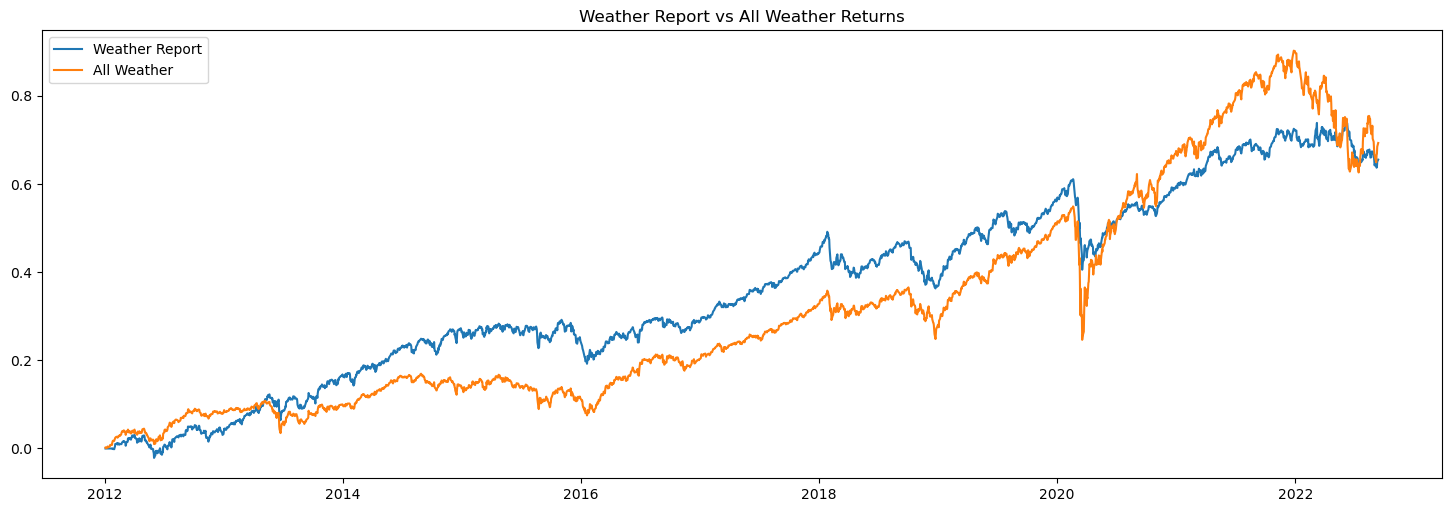

In [10]:
Plotter(test)

# View performance of each constituents

In [11]:
test.loc[:,'SPY_Signal':'SPY_Cash'].join(test.loc[:, 'SPY_Return':'SPY_Drawdown'])

,SPY_Signal,SPY_Position,SPY_Execution,SPY_Closing,SPY_Stock_Holding,SPY_Daily_Stock_Value,SPY_Capital,SPY_Cash,SPY_Return,SPY_Strategy Cumulative Returns,SPY_Hodling Returns,SPY_Max Gross Performance,SPY_Drawdown
Date,,,,,,,,,,,,,
2012-01-03,0.0,0.0,0,1,0,0.0,100000.000000,100000.000000,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.0,0.0,0,1,0,0.0,100000.000000,100000.000000,0.0,0.000000,0.001569,0.000000,0.000000
2012-01-05,0.0,0.0,0,1,0,0.0,100000.000000,100000.000000,0.0,0.000000,0.004235,0.000000,0.000000
2012-01-06,0.0,0.0,0,1,0,0.0,100000.000000,100000.000000,0.0,0.000000,0.001647,0.000000,0.000000
2012-01-09,0.0,0.0,0,1,0,0.0,100000.000000,100000.000000,0.0,0.000000,0.004078,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-06,0.0,0.0,0,1,0,0.0,140795.171486,140795.171486,0.0,0.407952,2.739351,0.491915,0.083963
2022-09-07,0.0,0.0,0,1,0,0.0,140795.171486,140795.171486,0.0,0.407952,2.806529,0.491915,0.083963
2022-09-08,0.0,0.0,0,1,0,0.0,140795.171486,140795.171486,0.0,0.407952,2.831409,0.491915,0.083963


# <a id='DD'>Drawdown Function</a>

In [12]:
def Drawdowns(df):  
      
    index = df[df['Drawdown'] == 0].index  
  
    a = []  
  
    for i in range(1,len(index)):  
        period = index[i].to_pydatetime() - index[i-1].to_pydatetime()  
        max_drawdown = df.loc[index[i-1]:index[i],'Drawdown'].max()  
        a.append([period,max_drawdown,index[i-1],index[i]])  
      
    df1 = pd.DataFrame(a,columns=['Period','Max Drawdown','Beginning','End']).sort_values('Max Drawdown',ascending=False)  
    df[["Max Gross Performance", "Strategy Cumulative Returns"]].dropna().plot(figsize=(15,8)) 
    plt.ylabel("Cumulative Returns") 
    plt.title("Drawdowns")
    return df1.head(5)

,Period,Max Drawdown,Beginning,End
320,350 days,0.205425,2020-02-19,2021-02-03
278,452 days,0.128546,2018-01-26,2019-04-23
171,280 days,0.099656,2015-11-03,2016-08-09
73,120 days,0.058413,2013-05-21,2013-09-18
167,182 days,0.055700,2015-04-24,2015-10-23


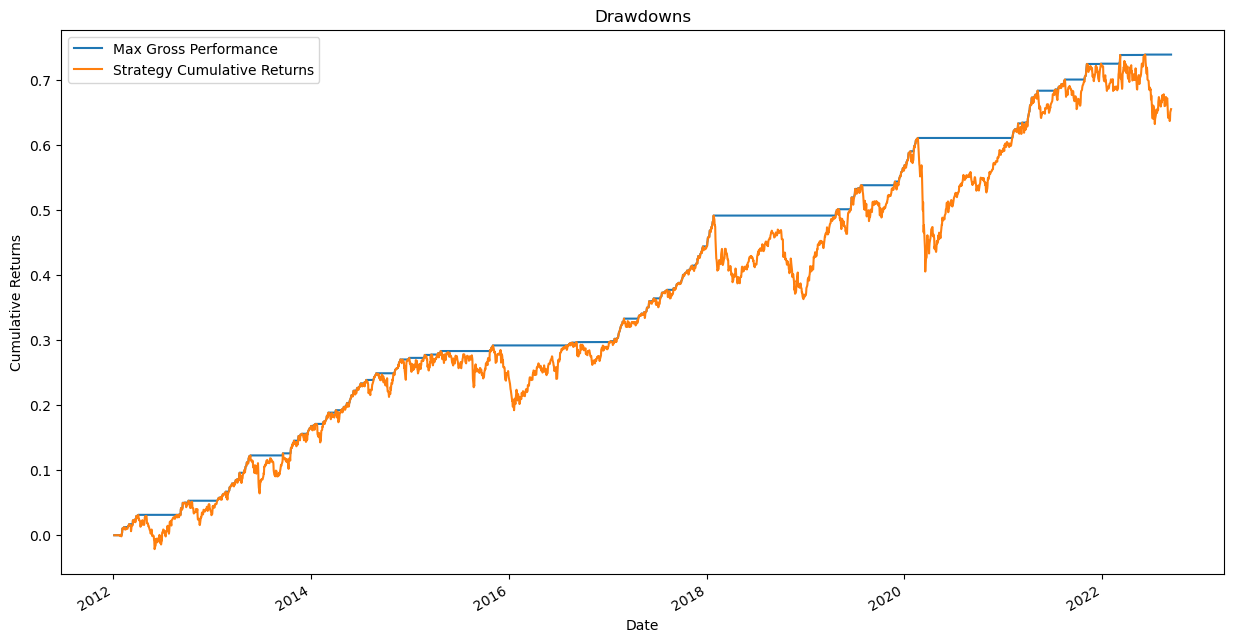

In [13]:
Drawdowns(test)

# <a id='SHA'>Sharpe Ratio Function</a>

In [14]:
def sharpe_ratio(df, periods_per_year = 252): 
     
    n_years = df.shape[0]/periods_per_year 
     
    annualized_return = np.power(np.prod(1 + df['Return']), (1 / n_years) 
                                 ) - 1 
     
    annualized_vol = df['Return'].std() * np.sqrt(periods_per_year) 
     
    annualized_sharpe = annualized_return / annualized_vol 
     
    print(f'Annualized Return : {round(annualized_return * 100,4)}%')
    print(f'Annualized Vol : {round(annualized_vol * 100,4)}%') 
    print(f'Annualized Sharpe : {round(annualized_sharpe,4)}')  

In [15]:
sharpe_ratio(test)

Annualized Return : 4.6583%
Annualized Vol : 5.7608%
Annualized Sharpe : 0.8086


# <a id='CAGR'>CAGR Calculation</a>

In [16]:
def CAGR(df):
    D = (df.index[-1] - df.index[0]).days
    CAGR = (((test["Total_Capital"][-1]) / (test["Total_Capital"][1])) ** (365.0/D)) - 1
    print(f'CAGR : {round(CAGR * 100,4)}%')

In [17]:
CAGR(test)

CAGR : 4.8236%
